In [6]:
# Here we import everything we need for the project

%matplotlib inline
#from google.colab import files
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

print(tf.__version__)

2.1.0


In [8]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk(".", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

20000


In [3]:
# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)

(240, 640)


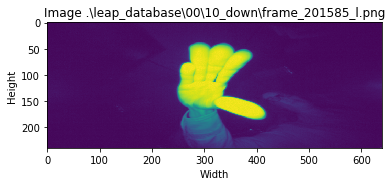

In [4]:
plot_image(imagepaths[1900]) #We plot the first image from our imagepaths array

In [ ]:
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
  img = cv2.imread(path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  X.append(img)
  
  # Processing label in image path
  category = path.split("\\")[3]
  label = int(category.split("_")[0][1]) # We need to convert 10_down to 00_down, or else it crashes
  y.append(label)

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 120, 320, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

In [127]:
X.shape

(20000, 120, 320, 1)

In [71]:
category

['.', 'leap_database', '00', '01_palm', 'frame_197957_r.png']

In [74]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

In [75]:
# Recreate the exact same model, including weights and optimizer.
# model = keras.models.load_model('handrecognition_model.h5')
# model.summary()

# To use the pre-trained model, just load it and skip to the next session.

In [76]:
# Import of keras model and hidden layers for our convolutional network
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

Using TensorFlow backend.


In [77]:
# Construction of model
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [78]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 116, 316, 32)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 158, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 156, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 78, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 76, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 38, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 31616)            

In [79]:
# Configures the model for training
model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

In [80]:
# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))

Train on 14000 samples, validate on 6000 samples
Epoch 1/5
 - 129s - loss: 1.2729 - accuracy: 0.9346 - val_loss: 0.0041 - val_accuracy: 0.9992
Epoch 2/5
 - 111s - loss: 0.0055 - accuracy: 0.9989 - val_loss: 0.0320 - val_accuracy: 0.9942
Epoch 3/5
 - 112s - loss: 0.0211 - accuracy: 0.9954 - val_loss: 0.0351 - val_accuracy: 0.9910
Epoch 4/5
 - 202s - loss: 0.0069 - accuracy: 0.9983 - val_loss: 0.0113 - val_accuracy: 0.9967
Epoch 5/5
 - 264s - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.0011 - val_accuracy: 0.9993


In [81]:
# Save entire model to a HDF5 file
model.save('handrecognition_model.h5')

In [82]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

6000/6000 [==============================] - 15s 3ms/step
Test accuracy: 99.93%


In [83]:
test_loss

0.0011034880769943054

In [84]:
predictions = model.predict(X_test) # Make predictions towards the test set

In [85]:
predictions

array([[1.17112715e-14, 4.12043013e-12, 1.98690009e-13, ...,
        3.74971000e-06, 8.45845394e-10, 1.23455123e-07],
       [9.44136341e-18, 1.00000000e+00, 1.34340520e-12, ...,
        2.21402183e-16, 1.51242387e-11, 7.14219691e-19],
       [4.89037630e-13, 4.26106928e-10, 2.53432986e-11, ...,
        5.36772501e-11, 6.36685672e-06, 6.71317391e-10],
       ...,
       [7.23634117e-16, 2.02941214e-06, 1.70535933e-10, ...,
        2.87330194e-11, 1.50873436e-09, 4.11703787e-12],
       [2.46315217e-18, 7.54202686e-18, 5.21436735e-13, ...,
        4.52050631e-17, 5.03958531e-17, 4.60552294e-22],
       [5.02500509e-21, 1.29861075e-23, 1.08313439e-18, ...,
        7.10590050e-31, 3.38234723e-24, 2.78905028e-27]], dtype=float32)

In [88]:
np.argmax(predictions[1]), y_test[1] # If same, got it right

(1, 1)

In [89]:
# Function to plot images and labels for validation purposes
def validate_9_images(predictions_array, true_label_array, img_array):
  # Array for pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
  plt.figure(figsize=(15,5))
  
  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
    
    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

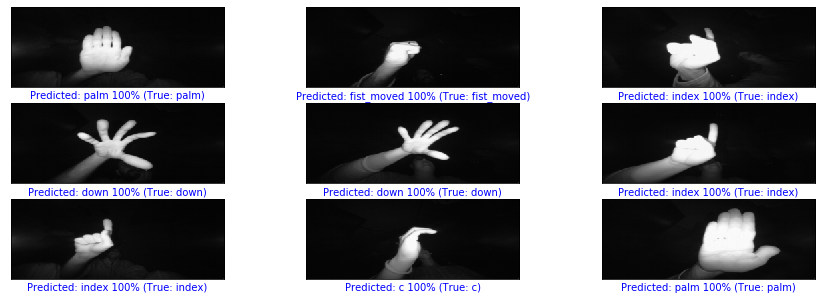

In [90]:
validate_9_images(predictions, y_test, X_test)

In [91]:
y_pred = np.argmax(predictions, axis=1) # Transform predictions into 1-D array with label number

In [92]:
# H = Horizontal
# V = Vertical

pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=["Predicted Thumb Down", "Predicted Palm (H)", "Predicted L", "Predicted Fist (H)", "Predicted Fist (V)", "Predicted Thumbs up", "Predicted Index", "Predicted OK", "Predicted Palm (V)", "Predicted C"],
             index=["Actual Thumb Down", "Actual Palm (H)", "Actual L", "Actual Fist (H)", "Actual Fist (V)", "Actual Thumbs up", "Actual Index", "Actual OK", "Actual Palm (V)", "Actual C"])

,Predicted Thumb Down,Predicted Palm (H),Predicted L,Predicted Fist (H),Predicted Fist (V),Predicted Thumbs up,Predicted Index,Predicted OK,Predicted Palm (V),Predicted C
Actual Thumb Down,604,0,0,0,0,0,0,0,0,0
Actual Palm (H),1,602,0,0,0,0,2,0,0,0
Actual L,0,0,599,0,0,0,1,0,0,0
Actual Fist (H),0,0,0,611,0,0,0,0,0,0
Actual Fist (V),0,0,0,0,591,0,0,0,0,0
Actual Thumbs up,0,0,0,0,0,568,0,0,0,0
Actual Index,0,0,0,0,0,0,596,0,0,0
Actual OK,0,0,0,0,0,0,0,586,0,0
Actual Palm (V),0,0,0,0,0,0,0,0,618,0
Actual C,0,0,0,0,0,0,0,0,0,621


In [94]:
img = cv2.imread('pp.png') # Reads image and returns np.array
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  

In [106]:
img

array([[ 5,  5,  4, ...,  3,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  3,  4],
       ...,
       [ 5,  5,  5, ...,  3,  5,  4],
       [ 4,  5,  5, ...,  4,  4,  4],
       [ 5,  4,  4, ..., 34, 10,  9]], dtype=uint8)

(240, 640)


Text(0.5, 1.0, 'Image pp.png')

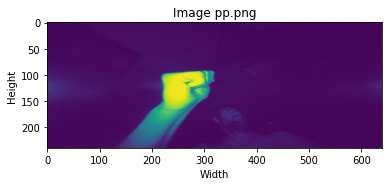

In [143]:
img = cv2.imread('pp.png') # Reads the image into a numpy.array
img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
print(img_cvt.shape) # Prints the shape of the image just to check
plt.grid(False) # Without grid so we can see better
plt.imshow(img_cvt) # Shows the image
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image " + 'pp.png')


#plot_image('pp.png')

In [144]:
img = np.array(img, dtype="uint8")
img = X1.reshape( 120, 320, 1) # Needed to reshape so CNN knows it's different images


In [146]:
img.reshape(120*320,1)

array([[ 5],
       [ 5],
       [ 4],
       ...,
       [34],
       [10],
       [ 9]], dtype=uint8)

In [10]:
from keras.datasets import mnist

Using TensorFlow backend.


In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [13]:
x_train.shape

(60000, 28, 28)